In [1]:
import pygrank
import networkx
import fairbench as fb

The default pygrank backend has been set to "numpy" by the file C:\Users\manio\.pygrank\config.json
Set your preferred backend as one of ["numpy", "pytorch", "tensorflow", "torch_sparse", "matvec", "sparse_dot_mkl"] and "reminder": false in that file to remove this message from future runs.


## Load data

In [3]:
_, graph, communities = next(pygrank.load_datasets_multiple_communities(["highschool"], graph_api=networkx))
print(graph, " "*20)

REQUIRED CITATION: Please visit the url http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks for instructions on how to cite the dataset highschool in your research


Graph with 156 nodes and 1437 edges                     


In [4]:
seeds = pygrank.to_signal(graph, communities[0]) # 2BIO1 class
sensitive = pygrank.to_signal(graph, communities[1]) # females
train, test = pygrank.split(seeds, 0.5)

## Run a node ranking algorithm

In [5]:
algorithm = pygrank.PageRank(alpha=0.85)
predictions = algorithm(train)
predictions = predictions*(1-train) >> pygrank.Top(20)
print(f"Positive train {train.np.sum():.0f}")
print(f"Positive preds {predictions.np.sum():.0f}")

Positive train 8
Positive preds 20


In [7]:
test_labels = test.filter(exclude=train)
test_preds = predictions.filter(exclude=train)
test_sensitive = sensitive.filter(exclude=train)
test_sensitive = fb.Fork(sensitive=fb.categories@test_sensitive)
test_sensitive.sum()

sensitive0.0,83
sensitive1.0,65


In [8]:
report = fb.multireport(labels=test_labels, predictions=test_preds, sensitive=test_sensitive)
report

accuracy,0.7230769230769231
pr,0.060240963855421686
tpr,0.0
tnr,0.9
accuracy,0.7896761133603238
pr,0.2610441767068273
tpr,0.0
tnr,0.9236842105263159
accuracy,0.19258572752548664
pr,0.1705282669138091
tpr,0.13333333333333333


## Run a fairness-aware node ranking algorithm

In [9]:
fair_algorithm = pygrank.LFPR(alpha=0.85, redistributor="original")
fair_predictions = fair_algorithm(train, sensitive=sensitive)
fair_predictions = fair_predictions*(1-train) >> pygrank.Top(20)
fair_test_preds = fair_predictions.filter(exclude=train)

fair_report = fb.multireport(labels=test_labels, predictions=fair_test_preds, sensitive=test_sensitive)
fair_report

accuracy,0.7846153846153846
pr,0.13253012048192772
tpr,0.09090909090909091
tnr,0.8928571428571429
accuracy,0.9044871794871795
pr,0.9571619812583668
tpr,0.8181818181818182
tnr,0.9054325955734407
accuracy,0.0828544949026877
pr,0.005931417979610748
tpr,0.020202020202020193


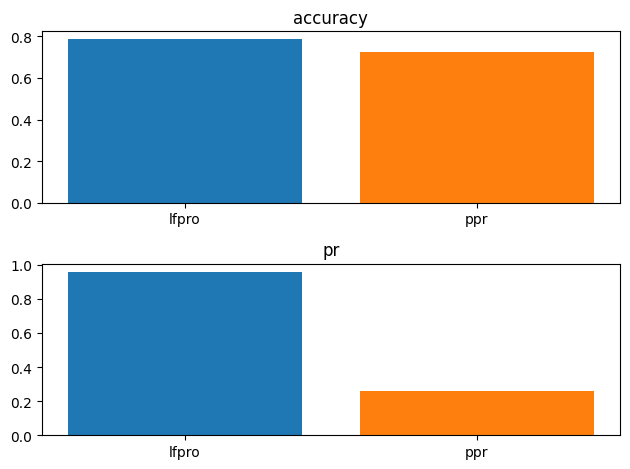

In [18]:
compare = fb.Fork(ppr=report, lfpro=fair_report)
compare = fb.extract(accuracy=compare.min, pr=compare.minratio)
fb.visualize(compare)

## fb.extract
Get entries from forks of dicts. All forks should have the same branches. <br>
**Example**: Use when gathering measure values from a fork of forks of dicts.

## fb.combine
Create a fork that creates a super-fork whose branches are a collection of all individual fork branches.<br>
**Example**: Use to add more columns to a fork of dicts.

## dictionary combination |
Applies dictionary combination to all branches between forks (the forks should have the same branch names).<br>
**Example**: Use to add more rows to a fork of dicts.

## fb.reduce
Reduce all branches to one with an appropriate procedure. <br>
If the fork has dictionary branches, these should have identical key sets. <br>
The result will also have the same key set.
*If `name=None` is provided, the result will be a raw tensor instead.*
**Example**: Aggregate all branch results into one greater result.